Import python packages

In [178]:
import os
import math
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Take the parsed .shr files (in .csv format)

In [179]:
# Taken when camera is off
normal_data = "parsed_SWEEP_REC_2024-03-12 20h42m01s_cam_off.csv"
normal_file_path = os.path.join('output_file', normal_data)

normal = pd.read_csv(normal_file_path)
normal

,2024-03-12 20:42:02.679000,2024-03-12 20:42:03.778000,2024-03-12 20:42:04.871000,2024-03-12 20:42:05.965000,2024-03-12 20:42:07.073000,2024-03-12 20:42:08.172000,2024-03-12 20:42:09.281000,2024-03-12 20:42:10.388000,2024-03-12 20:42:11.499000,2024-03-12 20:42:12.623000,...,2024-03-12 21:00:34.774000,2024-03-12 21:00:35.865000,2024-03-12 21:00:36.971000,2024-03-12 21:00:38.076000,2024-03-12 21:00:39.196000,2024-03-12 21:00:40.300000,2024-03-12 21:00:41.393000,2024-03-12 21:00:42.495000,2024-03-12 21:00:43.586000,2024-03-12 21:00:44.694000
0,-48.724518,-48.996180,-47.848446,-48.367440,-48.336704,-46.684868,-47.801810,-48.300430,-49.861420,-49.192238,...,-51.751705,-51.374336,-47.621998,-48.834126,-50.667797,-52.166714,-47.449425,-47.712900,-47.924706,-49.737430
1,-60.836773,-60.970444,-59.873615,-60.490017,-60.629650,-58.733006,-59.879000,-60.406937,-61.744843,-61.265050,...,-63.555620,-63.627740,-59.530754,-60.753063,-62.573296,-64.339070,-59.525322,-59.806583,-59.952827,-61.766026
2,-62.833588,-63.222580,-62.257990,-62.666153,-62.505726,-61.194520,-62.096413,-62.592520,-64.182110,-63.352325,...,-65.268610,-65.081090,-62.091946,-63.204600,-65.191770,-65.528690,-61.952076,-62.078285,-62.441685,-63.337190
3,-66.441860,-67.155880,-66.640660,-66.831730,-65.867990,-65.644585,-66.446070,-66.525730,-68.312610,-67.083374,...,-68.143400,-67.331660,-66.733030,-67.236110,-68.950430,-67.593720,-66.235054,-66.434555,-66.974890,-66.469740
4,-70.403110,-70.482430,-70.431430,-70.462150,-70.773415,-70.395680,-70.818890,-69.904045,-70.637650,-70.353920,...,-70.013220,-70.328500,-69.991280,-70.088010,-70.484810,-70.523990,-69.934680,-70.879140,-70.858020,-70.463450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76797,-74.725105,-74.715340,-75.012880,-74.889810,-74.622215,-74.837020,-74.746370,-74.653175,-74.619804,-74.390495,...,-74.321460,-74.708984,-74.922905,-74.627770,-74.713930,-75.059070,-74.746500,-74.427070,-74.959120,-74.542885
76798,-74.771095,-74.784810,-74.978355,-74.786644,-74.771470,-74.894424,-74.740670,-74.338100,-74.675900,-74.200140,...,-74.367040,-74.537445,-75.187100,-74.692500,-74.685930,-74.933350,-74.798000,-74.543420,-75.069190,-74.439920
76799,-74.721436,-74.594730,-74.890930,-74.669945,-74.697580,-74.702310,-74.585820,-74.123890,-74.537630,-73.958670,...,-74.443090,-74.453770,-75.100720,-74.466020,-74.647900,-74.862976,-74.849580,-74.540535,-74.932610,-74.354810
76800,-74.685460,-74.428320,-74.877590,-74.586050,-74.490440,-74.524300,-74.383970,-74.122810,-74.432300,-74.076180,...,-74.581330,-74.443560,-74.954490,-74.437860,-74.467920,-74.903680,-74.827240,-74.549255,-74.652770,-74.396390


In [180]:
# Taken when camera is on
anomaly_data = "parsed_SWEEP_REC_2024-03-12 20h27m34s_cam_on.csv"
anomaly_file_path = os.path.join('output_file', anomaly_data)

anomaly = pd.read_csv(anomaly_file_path)
anomaly

,2024-03-12 20:27:35.401000,2024-03-12 20:27:36.509000,2024-03-12 20:27:37.598000,2024-03-12 20:27:38.690000,2024-03-12 20:27:39.782000,2024-03-12 20:27:40.890000,2024-03-12 20:27:41.993000,2024-03-12 20:27:43.112000,2024-03-12 20:27:44.222000,2024-03-12 20:27:45.316000,...,2024-03-12 20:28:02.979000,2024-03-12 20:28:04.072000,2024-03-12 20:28:05.167000,2024-03-12 20:28:06.277000,2024-03-12 20:28:07.372000,2024-03-12 20:28:08.479000,2024-03-12 20:28:09.585000,2024-03-12 20:28:10.691000,2024-03-12 20:28:11.779000,2024-03-12 20:28:12.871000
0,-53.148163,-55.855984,-55.257446,-51.865630,-56.280777,-54.210674,-57.342370,-56.066000,-55.429600,-52.96578,...,-50.802280,-53.832840,-59.004982,-53.253613,-54.010326,-51.884026,-54.582775,-56.403496,-54.295444,-51.599300
1,-64.832825,-67.506920,-66.917620,-63.580650,-67.941284,-65.924820,-69.020485,-67.777695,-67.129110,-64.63182,...,-62.528310,-65.529040,-70.613464,-64.975590,-65.669205,-63.599520,-66.286680,-68.116140,-66.016620,-63.314453
2,-67.683590,-69.817764,-69.534424,-66.686485,-70.312830,-68.741030,-71.236460,-70.112010,-69.775390,-67.55281,...,-65.609420,-68.303400,-72.526610,-67.892390,-68.265140,-66.595825,-68.784840,-70.604645,-68.787926,-66.423065
3,-73.876360,-74.685460,-74.930970,-73.735750,-74.838110,-74.609600,-75.268250,-74.885320,-74.844260,-73.86268,...,-72.824530,-73.876090,-75.596540,-74.103500,-74.000390,-73.130490,-74.327720,-75.306050,-74.341570,-73.353170
4,-77.082820,-77.111084,-77.390526,-77.571144,-77.111990,-77.358696,-77.314960,-77.488945,-77.266960,-76.95422,...,-77.720726,-76.978830,-76.945530,-77.217750,-77.258575,-77.140820,-77.306270,-77.649360,-77.097960,-77.240790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76797,-74.851395,-75.014885,-74.726480,-75.020080,-74.764650,-75.456780,-74.864845,-74.746990,-75.102806,-75.24942,...,-74.819970,-74.724570,-75.305300,-74.839550,-74.712040,-74.590960,-75.265810,-74.841415,-74.906410,-74.920710
76798,-75.033460,-75.036514,-74.565100,-75.031120,-74.641960,-75.405150,-74.678360,-74.735610,-75.063156,-75.21438,...,-74.706840,-74.748245,-75.069780,-74.654390,-74.748130,-74.786316,-74.914860,-74.978540,-74.997734,-74.877530
76799,-75.164620,-74.941680,-74.497320,-74.803840,-74.471690,-75.362610,-74.642020,-74.700290,-74.889620,-75.14204,...,-74.783970,-74.760380,-74.887670,-74.568050,-74.870544,-74.904180,-74.579710,-75.139230,-74.965290,-74.836270
76800,-75.146100,-74.956280,-74.481880,-74.583200,-74.414880,-75.347015,-74.823780,-74.589430,-74.781650,-75.06950,...,-74.823180,-74.894550,-74.892480,-74.654430,-75.051070,-74.965130,-74.680650,-75.215965,-74.973694,-74.788666


#### Data Pre-Processing

In [181]:
START_FREQ = 0                  # 0.0 Hz 
END_FREQ = 6000000000           # 6.0 GHz
FREQ_BIN_SIZE = 78124.97688     # ~78.125 KHz

def preprocess_dataframe(df):
    # Transpose the DataFrame so that timestamps become the index
    df = df.transpose()

    num_columns = len(df.columns)  # Excluding the 'timestamp' column
    frequency_values = [START_FREQ + i * FREQ_BIN_SIZE for i in range(num_columns)]

    # Set data timestamp to be index column
    df.index.name='Timestamp'
    df.index = pd.to_datetime(df.index)

    # Name subsequent columns based on the frequency
    df.columns = frequency_values
    
    return df

Pre-process normal dataframe

In [182]:
normal_df = preprocess_dataframe(normal)
normal_df.head()

,0.000000e+00,7.812498e+04,1.562500e+05,2.343749e+05,3.124999e+05,3.906249e+05,4.687499e+05,5.468748e+05,6.249998e+05,7.031248e+05,...,5.999373e+09,5.999451e+09,5.999529e+09,5.999608e+09,5.999686e+09,5.999764e+09,5.999842e+09,5.999920e+09,5.999998e+09,6.000076e+09
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-12 20:42:02.679,-48.724518,-60.836773,-62.833588,-66.44186,-70.403110,-70.895226,-71.07942,-69.712670,-68.851105,-68.53038,...,-74.490070,-74.419110,-74.405075,-74.439660,-74.58493,-74.725105,-74.771095,-74.721436,-74.68546,-74.69284
2024-03-12 20:42:03.778,-48.996180,-60.970444,-63.222580,-67.15588,-70.482430,-70.884650,-70.82783,-69.637570,-68.760860,-68.29183,...,-74.247856,-74.288300,-74.305440,-74.496130,-74.63471,-74.715340,-74.784810,-74.594730,-74.42832,-74.47229
2024-03-12 20:42:04.871,-47.848446,-59.873615,-62.257990,-66.64066,-70.431430,-70.894930,-70.81046,-69.758990,-69.175460,-68.81282,...,-74.509880,-74.683754,-74.833150,-75.039160,-75.05128,-75.012880,-74.978355,-74.890930,-74.87759,-74.90511
2024-03-12 20:42:05.965,-48.367440,-60.490017,-62.666153,-66.83173,-70.462150,-71.302360,-71.24506,-69.957924,-69.338646,-68.59583,...,-74.832115,-74.874460,-74.856300,-74.919820,-74.99464,-74.889810,-74.786644,-74.669945,-74.58605,-74.49140
2024-03-12 20:42:07.073,-48.336704,-60.629650,-62.505726,-65.86799,-70.773415,-71.798035,-71.49753,-70.260730,-69.243805,-68.61491,...,-74.378870,-74.425190,-74.438800,-74.565315,-74.60680,-74.622215,-74.771470,-74.697580,-74.49044,-74.42918


Pre-process anomaly data as well

In [183]:
anomaly_df = preprocess_dataframe(anomaly)
anomaly_df.head()

,0.000000e+00,7.812498e+04,1.562500e+05,2.343749e+05,3.124999e+05,3.906249e+05,4.687499e+05,5.468748e+05,6.249998e+05,7.031248e+05,...,5.999373e+09,5.999451e+09,5.999529e+09,5.999608e+09,5.999686e+09,5.999764e+09,5.999842e+09,5.999920e+09,5.999998e+09,6.000076e+09
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-12 20:27:35.401,-53.148163,-64.832825,-67.683590,-73.87636,-77.082820,-77.55082,-77.889084,-78.15678,-78.377884,-78.590340,...,-74.697200,-74.59378,-74.516500,-74.577590,-74.756546,-74.851395,-75.033460,-75.16462,-75.14610,-74.965420
2024-03-12 20:27:36.509,-55.855984,-67.506920,-69.817764,-74.68546,-77.111084,-77.37895,-77.707520,-78.02619,-78.313990,-78.666990,...,-74.651300,-74.37111,-74.305176,-74.559944,-74.872910,-75.014885,-75.036514,-74.94168,-74.95628,-74.907730
2024-03-12 20:27:37.598,-55.257446,-66.917620,-69.534424,-74.93097,-77.390526,-77.72667,-77.968450,-78.12264,-78.254654,-78.303345,...,-74.750710,-74.74298,-74.607710,-74.677340,-74.859560,-74.726480,-74.565100,-74.49732,-74.48188,-74.558540
2024-03-12 20:27:38.690,-51.865630,-63.580650,-66.686485,-73.73575,-77.571144,-78.16291,-78.377884,-78.55718,-78.531110,-78.357340,...,-75.131940,-74.95140,-74.678790,-74.686554,-74.898315,-75.020080,-75.031120,-74.80384,-74.58320,-74.507965
2024-03-12 20:27:39.782,-56.280777,-67.941284,-70.312830,-74.83811,-77.111990,-77.48139,-78.006775,-78.44039,-78.483940,-78.660450,...,-75.234505,-75.33962,-75.169720,-75.110260,-75.018340,-74.764650,-74.641960,-74.47169,-74.41488,-74.583565


#### Visualization

Visualize normal_df's channel power at a single timestamp

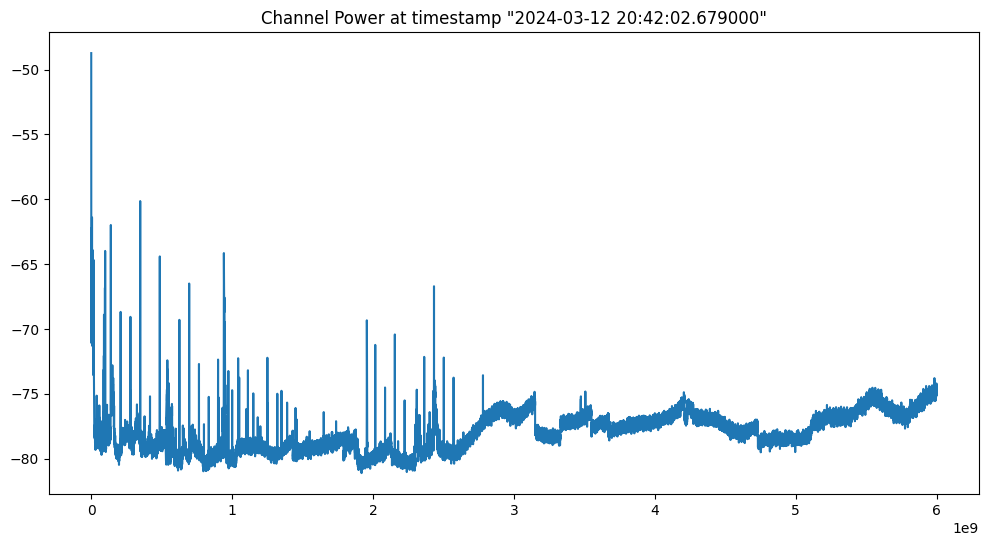

In [184]:
# Visualize the first three time-series capture
plt.figure(figsize=(12, 6))
plt.plot(normal_df.iloc[0])
plt.title('Channel Power at timestamp "{}"'.format(normal_df.iloc[0].name))
plt.show()

Visualize normal_df's channel power at five multiple timestamps

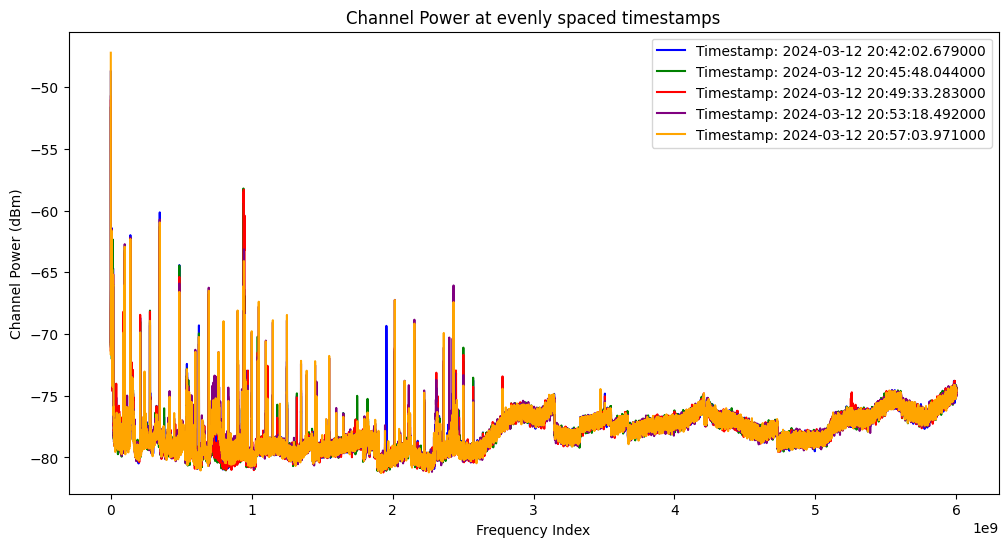

In [185]:
# Define the number of rows to plot
num_rows_to_plot = 5

# Select evenly spaced timestamps
timestamps = normal_df.index[::math.ceil(normal_df.shape[0] / num_rows_to_plot)]

# Select rows at the specified timestamps
selected_rows = normal_df.loc[timestamps]

# Define colors for each line
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Visualize the time-series capture
plt.figure(figsize=(12, 6))

# Plot each selected row with a different color and label
for i, (timestamp, values) in enumerate(selected_rows.iterrows()):
    plt.plot(values, label='Timestamp: {}'.format(timestamp), color=colors[i])

plt.title('Channel Power at evenly spaced timestamps')
plt.xlabel('Frequency Index')
plt.ylabel('Channel Power (dBm)')
plt.legend()
plt.show()


In [186]:
anomaly_df['IsAnomaly'] = 1
anomaly_df.head()

,0.0,78124.97688,156249.95376,234374.93064,312499.90752,390624.8844,468749.86128,546874.83816,624999.81504,703124.79192,...,5999451349.54584,5999529474.52272,5999607599.4996,5999685724.4764805,5999763849.453361,5999841974.43024,5999920099.40712,5999998224.384,6000076349.36088,IsAnomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-12 20:27:35.401,-53.148163,-64.832825,-67.683590,-73.87636,-77.082820,-77.55082,-77.889084,-78.15678,-78.377884,-78.590340,...,-74.59378,-74.516500,-74.577590,-74.756546,-74.851395,-75.033460,-75.16462,-75.14610,-74.965420,1
2024-03-12 20:27:36.509,-55.855984,-67.506920,-69.817764,-74.68546,-77.111084,-77.37895,-77.707520,-78.02619,-78.313990,-78.666990,...,-74.37111,-74.305176,-74.559944,-74.872910,-75.014885,-75.036514,-74.94168,-74.95628,-74.907730,1
2024-03-12 20:27:37.598,-55.257446,-66.917620,-69.534424,-74.93097,-77.390526,-77.72667,-77.968450,-78.12264,-78.254654,-78.303345,...,-74.74298,-74.607710,-74.677340,-74.859560,-74.726480,-74.565100,-74.49732,-74.48188,-74.558540,1
2024-03-12 20:27:38.690,-51.865630,-63.580650,-66.686485,-73.73575,-77.571144,-78.16291,-78.377884,-78.55718,-78.531110,-78.357340,...,-74.95140,-74.678790,-74.686554,-74.898315,-75.020080,-75.031120,-74.80384,-74.58320,-74.507965,1
2024-03-12 20:27:39.782,-56.280777,-67.941284,-70.312830,-74.83811,-77.111990,-77.48139,-78.006775,-78.44039,-78.483940,-78.660450,...,-75.33962,-75.169720,-75.110260,-75.018340,-74.764650,-74.641960,-74.47169,-74.41488,-74.583565,1


In [187]:
# Merge normal data with anomaly data
combined_data = pd.concat([normal_df, anomaly_df.drop(columns=['IsAnomaly'])])
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052 entries, 2024-03-12 20:42:02.679000 to 2024-03-12 20:28:12.871000
Columns: 76802 entries, 0.0 to 6000076349.36088
dtypes: float64(76802)
memory usage: 616.4 MB


#### Trained combined data

In [188]:
# Extract values from combine data
X = combined_data.values
# Label the data (0 for normal, 1 for anomalies)
y = np.concatenate([np.zeros(len(normal_df)), np.ones(len(anomaly_df))])  

In [189]:
# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[Optional] Save data used for training and testing

In [194]:
# Create a folder named 'train_data' if it doesn't exist
train_data_folder = 'train_data'
if not os.path.exists(train_data_folder):
    os.makedirs(train_data_folder)

# Save X_train, X_test, y_train, and y_test as text files in 'train_data' folder
np.savetxt(os.path.join(train_data_folder, 'X_train.txt'), X_train)
np.savetxt(os.path.join(train_data_folder, 'X_test.txt'), X_test)
np.savetxt(os.path.join(train_data_folder, 'y_train.txt'), y_train)
np.savetxt(os.path.join(train_data_folder, 'y_test.txt'), y_test)

In [190]:
# Step 3: Feature Engineering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
# Step 4: Model Selection and Training
model = IsolationForest(contamination='auto', random_state=42)  # contamination is the proportion of outliers
model.fit(X_train_scaled)

IsolationForest(random_state=42)

In [192]:
# Step 5: Model Evaluation
predictions = model.predict(X_test_scaled)
predictions[predictions == 1] = 0  # Inliers
predictions[predictions == -1] = 1  # Outliers

In [193]:
predictions.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [162]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       204
         1.0       1.00      0.57      0.73         7

    accuracy                           0.99       211
   macro avg       0.99      0.79      0.86       211
weighted avg       0.99      0.99      0.98       211



#### Save generated model for deployment

In [169]:
# Create the directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Step 6: Save the trained model
model_path = os.path.join(models_dir, 'isolation_forest_model.pkl')
joblib.dump(model, model_path)

['models\\isolation_forest_model.pkl']